## Imports

In [9]:
import cv2, os
import random,shutil
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers, Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from tensorflow.keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential, load_model
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization

In [10]:
!ls /kaggle/input/drowsiness-detection

closed_eye  open_eye


In [11]:
data_dir = '/kaggle/input/drowsiness-detection'

## Image Data Generator and Data Augmentation

In [14]:
def generator(dir, gen=image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),
              class_mode='categorical' ):

    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',
                                   class_mode=class_mode,target_size=target_size)

batch= 32
target=(24,24)
train_batch = generator(data_dir,shuffle=True, batch_size=batch,target_size=target)
valid_batch = generator(data_dir,shuffle=True, batch_size=batch,target_size=target)
size_per_epoch= len(train_batch.classes)//batch
validation_size = len(valid_batch.classes)//batch
print(size_per_epoch,validation_size)

Found 48000 images belonging to 2 classes.
Found 48000 images belonging to 2 classes.
1500 1500


## Using Basic CNN Architecture

In [15]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    #32 convolution filters used each of size 3x3 again
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    #64 convolution filters used each of size 3x3 choose the best features via pooling
    #randomly turn neurons on and off to improve convergence
    Dropout(0.25),
    #flatten since too many dimensions, we only want a classification output
    Flatten(),
    #fully connected to get all relevant data
    Dense(128, activation='relu'),
    #one more dropout for convergence' sake :) 
    Dropout(0.5),
    #output a softmax to squash the matrix into output probabilities
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)       

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(train_batch, validation_data=valid_batch,epochs=2,steps_per_epoch=size_per_epoch ,validation_steps=validation_size)
model.save('CNN_Drowsiness.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
1500/1500 [==============================] - 165s 109ms/step - loss: 0.2647 - accuracy: 0.8829 - val_loss: 0.0560 - val_accuracy: 0.9805
Epoch 2/2
1500/1500 [==============================] - 85s 56ms/step - loss: 0.0690 - accuracy: 0.9759 - val_loss: 0.0410 - val_accuracy: 0.9851


## Using ResNet-50 Transfer Learning Technique

In [17]:
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory( data_dir,
                                                     target_size=(224,224),
                                                     batch_size=100,
                                                     shuffle=True,
                                                     class_mode='binary',
                                                     subset='training')

validation_datagen = ImageDataGenerator(validation_split=0.3,
                                        preprocessing_function=preprocess_input)

validation_generator =  validation_datagen.flow_from_directory( data_dir,
                                                                target_size=(224,224),
                                                                batch_size=100,
                                                                class_mode='binary',
                                                                subset='validation')  

Found 33600 images belonging to 2 classes.
Found 14400 images belonging to 2 classes.


In [18]:
model_res50 = Sequential()

model_res50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))

model_res50.add(Dense(1, activation='sigmoid'))
model_res50.layers[0].trainable = False 
model_res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
model_res50.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model_res50.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    validation_steps=steps_per_epoch_validation,
    epochs=3,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/3
336/336 [==============================] - 161s 471ms/step - loss: 0.1659 - accuracy: 0.9387 - val_loss: 0.1886 - val_accuracy: 0.9335
Epoch 2/3
336/336 [==============================] - 161s 481ms/step - loss: 0.0330 - accuracy: 0.9913 - val_loss: 0.1721 - val_accuracy: 0.9390
Epoch 3/3
336/336 [==============================] - 151s 450ms/step - loss: 0.0275 - accuracy: 0.9921 - val_loss: 0.1907 - val_accuracy: 0.9369


In [20]:
model_res50.save('ResNet50_Drowsiness.h5')

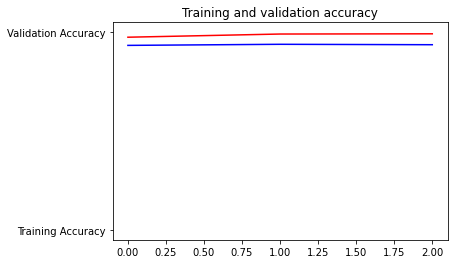

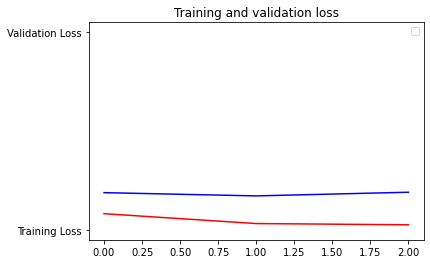

In [21]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()